In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.utils import *
from torch_geometric.data import Data
import torch
import random
import numpy as np
random.seed()
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GNNExplainer
import networkx as nx
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Making Synthetic Dataset of a Clique

In [3]:
def get_label(X, E, k_1, k_2):
    '''
    X: Node Feature Set
    E: Edge Index
    k_1: Const. for s(x)
    k_2: Const. for n(x)
    '''
    Ft_Sum = torch.sum(X,dim=1,keepdim=True)
    S = torch.exp(Ft_Sum - k_1)
    N = torch.exp(Ft_Sum - k_2)
    A = to_dense_adj(E)
    A = A.squeeze()
    N = torch.matmul(A, N)
    F = S + N
    P = 1/(1+F)
    Y = torch.bernoulli(P)
    # Y = Y.long()
    return Y, P

In [4]:
# of Nodes
V = 2000
clique_size = 5
train_index = int(V*0.7)
val_index = int(V*0.7)+int(V*0.15)

In [5]:
N1 = torch.normal(mean=2, std=1.0,size = (V,3))
N2 = torch.normal(mean=-2, std=1.0,size = (V,3))
Prob = torch.rand(V,3)
X = torch.where(Prob>0.5, N1, N2)

In [16]:
for i in range(int(V/clique_size)):
    if i == 0:
        CQ = nx.complete_graph(clique_size)
    else:
        cq = nx.complete_graph(clique_size)
        CQ = nx.disjoint_union(CQ,cq)

data = from_networkx(CQ)

#transofrm features into an exponent of them
Exp_X = torch.exp(X)
#unimportant features
Extension = torch.exp(torch.normal(mean=0.0, std=1.0,size=(V,2)))
data.x = torch.cat((Exp_X, Extension), 1)
#label
Y,P = get_label(X, data.edge_index, 3, 5)
data.y = Y
# train val test mask
train = torch.zeros(V, dtype=torch.bool)
val = torch.zeros(V, dtype=torch.bool)
test = torch.zeros(V, dtype=torch.bool)
train[:train_index] = True
val[train_index:val_index] = True
test[val_index:] = True
data.train_mask = train
data.val_mask = val
data.test_mask = test

tensor(976.)
tensor(1024.)


<BarContainer object of 2 artists>

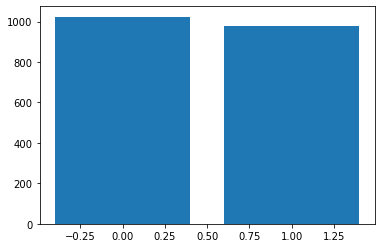

In [17]:
#label distribution
ones = Y.sum()
print(ones)
zeros = V - ones
print(zeros)
plt.bar([0,1],[zeros,ones])

In [19]:
data_x = pd.DataFrame(data.x)
data_x.to_csv('./Synthetic_Data/Clique_Data/data_x')
data_edge_index = pd.DataFrame(data.edge_index)
data_edge_index.to_csv('./Synthetic_Data/Clique_Data/data_edge_index')
data_y = pd.DataFrame(data.y)
data_y.to_csv('./Synthetic_Data/Clique_Data/data_y')
data_P = pd.DataFrame(P)
data_P.to_csv('./Synthetic_Data/Clique_Data/bernoulli_prob')
data_train_mask = pd.DataFrame(data.train_mask)
data_train_mask.to_csv('./Synthetic_Data/Clique_Data/data_train_mask')
data_val_mask = pd.DataFrame(data.val_mask)
data_val_mask.to_csv('./Synthetic_Data/Clique_Data/data_val_mask')
data_test_mask = pd.DataFrame(data.test_mask)
data_test_mask.to_csv('./Synthetic_Data/Clique_Data/data_test_mask')

In [20]:
## Optimal Prediction
pred = torch.round(P)  # Use the class with highest probability.
correct = pred == data.y  # Check against ground-truth labels.
# print(correct.sum())
val_acc = int(correct.sum())/V  # Derive ratio of correct predictions.
print(val_acc)

0.803


In [21]:
data.to(device)

Data(edge_index=[2, 8000], num_nodes=2000, x=[2000, 5], y=[2000, 1], train_mask=[2000], val_mask=[2000], test_mask=[2000])

In [23]:
#Testing True Data Distribution with Dataset that has unimportant features masked with 0
test_eval_x = torch.cat((Exp_X, torch.zeros(V,2)),1)
test_eval_data = from_networkx(CQ)
test_eval_data.x = test_eval_x
test_eval_data.y = Y
test_eval_data.test_mask = test
test_eval_data.to(device)

Data(edge_index=[2, 8000], num_nodes=2000, x=[2000, 5], y=[2000, 1], test_mask=[2000])

In [24]:
@torch.no_grad()
def Create_Samples(X, E, mask, p_1=0.5, p_2=0.5):
    '''
    Create a dataset for samples
    X: Node Features
    E: Edge Index
    mask: the mask token to be used
    p_1: the bernoulli prob. of masking for adjacency matrix
    p_2: the bernoulli prob. of masking for features
    '''
    # Number of Nodes
    V = X.size()[0] 
    # Number of Features
    F = X.size()[1]

    ## sampling random adjacency matrix
    #Original Adj Matrix
    A = to_dense_adj(E)
    #Prob of Keeping Adj Matrix
    P_adj = torch.rand(1,V,V).to(device)
    C = torch.mul(A,P_adj)
    #n stacks of Sample Adj Matrix
    Sample_Adj = C > p_1
    Sample_Adj,_ = dense_to_sparse(Sample_Adj)
    
    ## sampling random features
    P_feature = torch.rand(1,F).to(device)
    # Mask_feature = mask*torch.ones(1,F,dtype=torch.double).to(device)
    mask = torch.as_tensor(mask, dtype=torch.float).to(device)
    # mask = mask.double()
    # print(mask)
    # prob = torch.as_tensor(1-p_2, dtype=torch.double).to(device)
    # prob = (1-p_2)*torch.ones(1,F,dtype=torch.double).to(device)
    SF = torch.where(P_feature>(1-p_2),mask,X.float())
    Sample_Ft = SF
    
    return Sample_Ft, Sample_Adj

In [40]:
class Model(torch.nn.Module):
    def __init__(self, num_features, mask=-0.1, p_1=0, p_2=0):
        super(Model, self).__init__()
        self.fc0 = nn.Linear(num_features, 16)
        self.fc1 = nn.Linear(16, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv1 = GCNConv(16, 16)
        self.fc2 = nn.Linear(16, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.mask = False
        self.mask_param = [mask, p_1, p_2]

    def forward(self, x, edge_index):
        if self.mask == False:
            E = edge_index
            X = x
            self.mask = True
        else:
            X, E = Create_Samples(x, edge_index, self.mask_param[0], self.mask_param[1], self.mask_param[2])
        x = self.fc0(X)
        x = self.relu(x)
        x = self.fc1(X)
        x = self.relu(x)
        x = self.bn1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, E)
        x = self.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
    def change_param(self, mask, p_1, p_2):
        self.mask_param = [mask,p_1,p_2]

    def mask_off(self):
        self.mask = False
        
model = Model(num_features=5, mask=0, p_1 = 0, p_2=0)
print(model)

Model(
  (fc0): Linear(in_features=5, out_features=16, bias=True)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(16, 16)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [41]:
@torch.no_grad()
def validate(model):
    model.eval()
    model.mask_off()
    out = model(data.x, data.edge_index)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    pred = torch.round(out)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_loss, val_acc

@torch.no_grad()
def test(model):
    model.eval()
    model.mask_off()
    out = model(data.x, data.edge_index)
    pred = torch.round(out) # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

@torch.no_grad()
def test_eval(model):
    model.eval()
    model.mask_off()
    out = model(test_eval_data.x, test_eval_data.edge_index)
    pred = torch.round(out) # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [42]:
from IPython.display import clear_output
@torch.no_grad()
def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.show()

In [43]:
@torch.no_grad()
def save_plot(data_dict, figsize=(7,5), title=''):
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.savefig(f'{title}.png')

Model Trained on the Full Feature Set

In [44]:
model = Model(num_features=5, mask=0, p_1 = 0, p_2=0)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCELoss()

def train(epoch):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

losses = {'train':[], 'val': []}

best_loss = 100
final_epoch = 0
for epoch in range(1, 500):
    loss = train(epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_batch_losses = []
    train_batch_losses.append(loss.cpu())
    val_batch_losses = []
    val_loss, val_acc = validate(model)
    val_batch_losses.append(val_loss.cpu())
    
    if val_loss < best_loss:
        torch.save(model.state_dict(), './Models/Models_Clique/Full_Feature_1.pt')
        best_loss = val_loss
        final_epoch = epoch
    
    losses['train'].append(train_batch_losses)
    losses['val'].append(val_batch_losses)
    live_plot(losses)
    print(f'Val Accuracy: {val_acc:.4f}')
    print('best model taken from epoch:', final_epoch)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2000x5 and 16x16)

In [33]:
model = Model(num_features=5, mask=0, p_1 = 0, p_2=0)
model.load_state_dict(torch.load('./Models/Models_Clique/Full_Feature_1.pt'))
model.to(device)
model.change_param(0,0,0)
_, val_acc = validate(model)
print('Validation:',val_acc)
test_acc = test(model)
print('Test:',test_acc)
test_masked_acc = test_eval(model)
print('Test on Masked Unimp:',test_masked_acc)

Validation: 0.6866666666666666
Test: 0.72
Test on Masked Unimp: 0.73


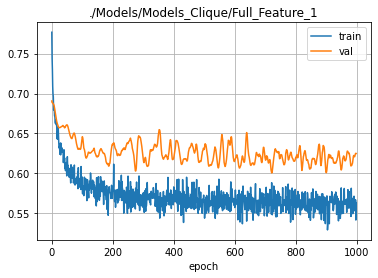

In [34]:
save_plot(losses, title='./Models/Models_Clique/Full_Feature_1')